# Notebook pour le tracé des cartes d'indicateurs VHI (RASTERS)

### Initialisation contexte test appli

In [22]:
import os

WRK_DIR = os.path.normpath('D:/MATHIS/0_Projet_Secheresse/1_Scripts/toolbox/eo4dm-oeil/EO4DM')
os.chdir(WRK_DIR)
WRK_DIR= os.path.join('Y:/EO4DM')

TERRITORY = 'New Caledonia (Fr)'
PRODUCT = 'VHI'
PERIOD = 'MONTH'
DATE = '201911'

TERRITORY_str = TERRITORY.replace(' ', '_').replace('(', '').replace(')', '')
DATA_HISTO = os.path.join(WRK_DIR,'DATA_HISTO',TERRITORY_str)
ANNEX_DIR = os.path.join(WRK_DIR,'ANNEX',TERRITORY_str)
INDIR_RASTERS = os.path.join(DATA_HISTO,'1_INDICATEURS/GLOBAL',PERIOD)
INDIR_ANNEX = os.path.join(ANNEX_DIR,'Areas')


In [23]:
import glob
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.plot import show

### Prépare le dossier de sortie

In [24]:
# --- Generate directories/sub-directories ---
OUTDIR_MAPS = os.path.join(WRK_DIR, f'PLOT_MAP_DROUGHT_{TERRITORY_str}')
os.umask(0) # used to reset the directories permission
if not os.path.exists(OUTDIR_MAPS):
    os.makedirs(OUTDIR_MAPS)
    os.chmod(OUTDIR_MAPS, 0o777)

### Lecture et préparation des données

In [25]:
raster_in = glob.glob(os.path.join(INDIR_RASTERS, f'*{PRODUCT}*{DATE}*.tif'))[0]
contours_in = glob.glob(os.path.join(INDIR_ANNEX, '*.shp'))[0]
gdf_contours = gpd.read_file(contours_in)

### Affichage et export de la carte

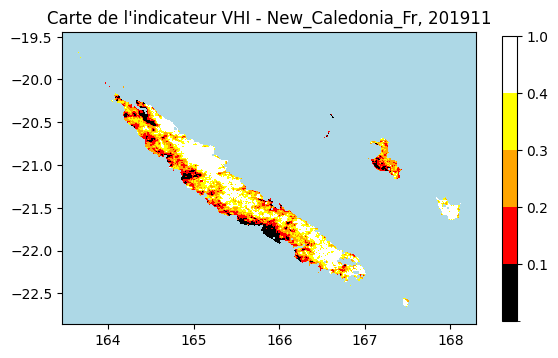

In [26]:
with rasterio.open(raster_in) as src:
    raster_data = src.read(1)
    bounds = src.bounds

    cmap = mcolors.ListedColormap(['black', 'red', 'orange', 'yellow', 'white'])
    boundaries = [0, 0.1, 0.2, 0.3, 0.4, 1]
    norm = mcolors.BoundaryNorm(boundaries, cmap.N, clip=True)

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.set_facecolor('#add8e6') # bleur clair
    gdf_contours.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

    if TERRITORY=='Fiji' or TERRITORY=='Vanuatu':
        for geometry in gdf_contours['geometry']:
            if geometry.geom_type == 'Polygon':
                ax.add_patch(plt.Polygon(list(geometry.exterior.coords), facecolor='lightgrey', zorder=-1))
            elif geometry.geom_type == 'MultiPolygon':
                for poly in geometry.geoms:
                    ax.add_patch(plt.Polygon(list(poly.exterior.coords), facecolor='lightgrey', zorder=-1))

    im = ax.imshow(raster_data, cmap=cmap, norm=norm, extent=(bounds.left, bounds.right, bounds.bottom, bounds.top))
    cbar  = plt.colorbar(im, ax=ax, ticks=[0.1, 0.2, 0.3, 0.4, 1], format="%1.1f", shrink=0.5)
    plt.title(f'Carte de l\'indicateur {PRODUCT} - {TERRITORY_str}, {DATE}')
    plt.tight_layout()
    plt.show()


    fig.savefig(os.path.join(OUTDIR_MAPS, f'maps_{PRODUCT}_{TERRITORY_str}_{DATE}.png'), dpi=300)
